## **GIS 강의 3주차**

---

### **1. 대구, 경북, 낙동강 shp 파일 불러오기**
* 1-1) 데이터 import 

### **2. 공간 데이터 핸들링**
* 2-1) 데이터 확인
* 2-2) 대구, 경북 하천용도 공간 데이터 핸들링 
* 2-3) 누락 하천구역 추가하기
* 2-4) 구글 API 로 수질측정 지역 위경도 추출
* 2-5) 공간결합 (시도,시군구,행정동) 

----


In [73]:
import os 
import sys 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd 
import re 

import folium
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from pandas_profiling import ProfileReport
import googlemaps
import warnings

In [5]:
# Jupyter 환경 설정 

warnings.filterwarnings(action='ignore') 
plt.rcParams['font.family']='AppleGothic'
file_path='/Users/dk/Documents'
os.chdir(file_path)

In [13]:
os.listdir('./data/')

['daegu_gyeongbuk',
 'starbucks.csv',
 'korea_sig_shp',
 '.DS_Store',
 'nakdong_river',
 'korea_adm_shp',
 'daegu_river',
 'water_quality_measure_spot.csv',
 'nakdong_river_modify',
 'korea_sido_shp',
 'gyeongbuk_river_shp']

---

### 1. 대구,경북,낙동강 shp 파일 불러오기 

#### 1-1) Data import 

In [14]:
# 시도 
korea_sido_shp=gpd.read_file(
	filename='./data/korea_sido_shp/ctp_rvn.shp',
	encoding='EUC-KR'
)

# 시군구 
korea_sig_shp = gpd.read_file(
	filename='./data/korea_sig_shp/sig.shp',
	encoding='EUC-KR'
)

# 행정동 
korea_adm_shp = gpd.read_file(
	filename='./data/korea_adm_shp/emd.shp',
	encoding='EUC-KR'
)

# 경북, 대구 낙동강 수계 shp (Bessel 보정된 중부원점 (TM)) 

gyeongbuk_river_shp = gpd.read_file(
	filename='./data/gyeongbuk_river_shp/LSMD_CONT_UJ201_47_202209.shp',
	encoding='EUC-KR'
)

daegu_river_shp = gpd.read_file(
	filename='./data/daegu_river_shp/LSMD_CONT_UJ201_27_202209.shp',
	encoding='EUC-KR'
)



---

### 2. 공간데이터 핸들링 

#### 2-1) 데이터 핸들링
#### 2-2) 대구, 경북 하천용도 구역 데이터 결합하기 
#### 2-3) 공간 데이터 핸들링 
#### 2-4) 낙동강 지역 필터링

---

#### 2-1) 데이터 핸들링

In [15]:
# 컬럼명 소문자로 변경 

korea_sido_shp.columns = map(str.lower, korea_sido_shp.columns)
korea_sig_shp.columns = map(str.lower, korea_sig_shp.columns)
korea_adm_shp.columns = map(str.lower, korea_adm_shp.columns)
gyeongbuk_river_shp.columns = map(str.lower, gyeongbuk_river_shp.columns)
daegu_river_shp.columns = map(str.lower, daegu_river_shp.columns)


* 안쓰는 컬럼 drop, 컬럼명 rename


In [16]:
# 경북지역 확인 
gyeongbuk_river_shp.head()

,mnum,alias,remark,ntfdate,sgg_oid,col_adm_se,geometry
0,64700004711020220032UJB1000001002,지방하천(곡강천),None,None,1340,47110,"POLYGON ((404364.980 298591.245, 404374.554 29..."
1,64700004711020110083UJB1000001001,병보천(지방하천),None,None,33,47110,"POLYGON ((384977.599 309716.307, 384977.775 30..."
2,15000004711020090370UJB1000001001,국가하천 형산강,None,None,34,47110,"POLYGON ((407012.212 279653.943, 407020.450 27..."
3,64700004711020210376UJB1000100001,하천구역,자호천,20211115,1335,47110,"POLYGON ((391893.153 304067.818, 391917.156 30..."
4,64700004711020140418UJB1000001002,청하천,None,20141201,50,47110,"POLYGON ((407183.618 304680.973, 407195.229 30..."


In [17]:
# 대구지역 확인 
daegu_river_shp.head()

,mnum,alias,remark,ntfdate,sgg_oid,col_adm_se,geometry
0,62700002714020090203UJB1000001001,율하천,하천부근토지에 대해서는 건설과 문의바람,None,38,27140,"POLYGON ((351720.976 264490.404, 351744.445 26..."
1,62700002714020100169UJB1000003000,지묘천,홍수피해예방(하천기본계획 재수립),None,39,27140,"POLYGON ((346790.934 275636.553, 346792.601 27..."
2,62700002714020100169UJB1000002000,용수천,홍수피해예방(하천기본계획 재수립),None,40,27140,"POLYGON ((349954.140 278370.776, 349966.041 27..."
3,62700002714020100169UJB4000001000,용수천,홍수피해예방 (하천기본계획 재수립),None,41,27140,"MULTIPOLYGON (((351070.968 276024.002, 351071...."
4,16132812714020200618UJB1000001001,금호강,국가하천,20201218,1649,27140,"POLYGON ((346790.580 268322.537, 346793.156 26..."


In [18]:
# 미사용 컬럼 drop 

gyeongbuk_river_shp.drop(
	columns=[
		'mnum',
		'remark',
		'ntfdate',
		'sgg_oid',
	],
	inplace=True
)


daegu_river_shp.drop(
	columns=[
		'mnum',
		'remark',
		'ntfdate',
		'sgg_oid',
	],
	inplace=True
)





In [19]:
# {시도 : sido, 시군구 :sig, 행정동 : adm}

korea_sido_shp.rename(
	columns={
		'ctprvn_cd': 'sido_cd',
		'ctp_eng_nm': 'sido_eng_nm',
		'ctp_kor_nm': 'sido_kor_nm'
	},
	inplace=True
)

#행정동 

korea_adm_shp.rename(
	columns={
		'emd_cd': 'adm_cd',
		'emd_eng_nm': 'adm_eng_nm',
		'emd_kor_nm': 'adm_kor_nm'
	},
	inplace=True
)

# 경북 강

gyeongbuk_river_shp.rename(
	columns={
		'alias': 'river_nm',
		'col_adm_se': 'sig_cd'
	},
	inplace=True
)

# 대구 강 

daegu_river_shp.rename(
	columns={
		'alias': 'river_nm',
		'col_adm_se': 'sig_cd'
	},
	inplace=True
)



---
#### 2-2) 대구, 경북 하천용도 공간 데이터 핸들링


In [20]:

river_shp = pd.concat(
	[
		gyeongbuk_river_shp,
		daegu_river_shp
	],
	ignore_index=True
)

river_shp.head()

,river_nm,sig_cd,geometry
0,지방하천(곡강천),47110,"POLYGON ((404364.980 298591.245, 404374.554 29..."
1,병보천(지방하천),47110,"POLYGON ((384977.599 309716.307, 384977.775 30..."
2,국가하천 형산강,47110,"POLYGON ((407012.212 279653.943, 407020.450 27..."
3,하천구역,47110,"POLYGON ((391893.153 304067.818, 391917.156 30..."
4,청하천,47110,"POLYGON ((407183.618 304680.973, 407195.229 30..."


* epsg 좌표계 변환 (5179로 전부 통일)

In [21]:
korea_sido_shp=korea_sido_shp.to_crs({'init': 'epsg:5179'})
korea_sig_shp=korea_sig_shp.to_crs({'init': 'epsg:5179'})
korea_adm_shp=korea_adm_shp.to_crs({'init': 'epsg:5179'})
river_shp=river_shp.to_crs({'init': 'epsg:5179'})

* 대구 경북 지역만 추출 (대구 :27 , 경북 : 47)


In [285]:
sido_cond=korea_sido_shp['sido_cd'].isin(['27','47'])
sig_cond=korea_sig_shp['sig_cd'].str[0:2].isin(['27','47'])
adm_cond=korea_adm_shp['adm_cd'].str[0:2].isin(['27','47'])


dgb_sido_shp=korea_sido_shp[sido_cond]
dgb_sig_shp=korea_sig_shp[sig_cond]
dgb_adm_shp=korea_adm_shp[adm_cond]

# 울릉군 제외 (낙동강과 무관)

dgb_sig_shp = dgb_sig_shp[dgb_sig_shp.sig_kor_nm != '울릉군']

# 울릉도 코드 47940
dgb_adm_shp = dgb_adm_shp[~dgb_adm_shp.adm_cd.str[0:5].isin(['47940'])]


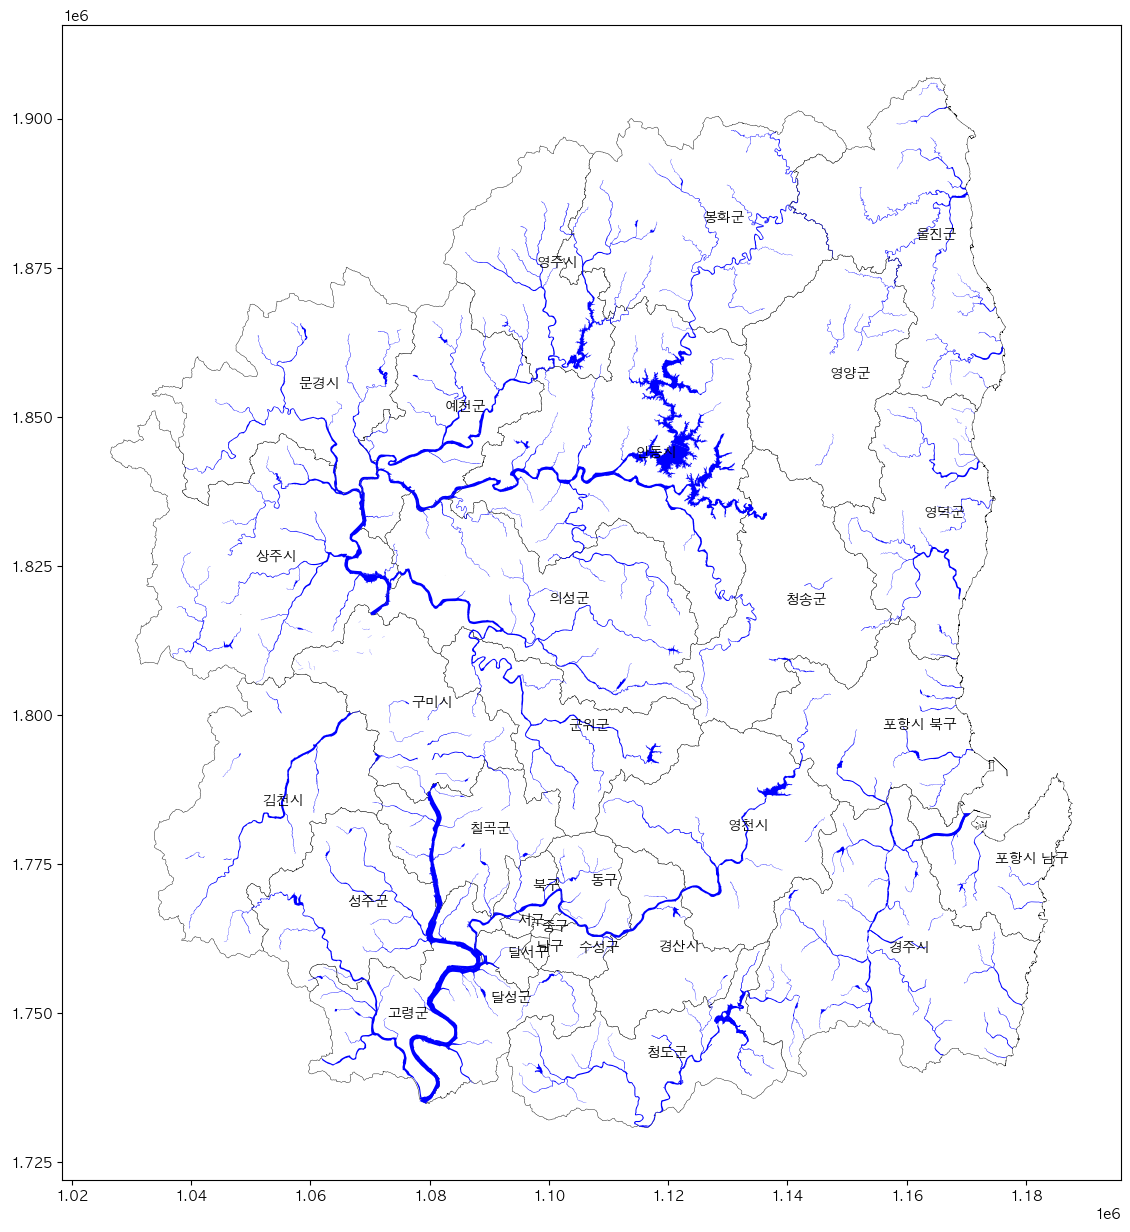

In [23]:
fig, ax=plt.subplots(1,1,figsize=(15,15)) 


spot_x = dgb_sig_shp.centroid.x
spot_y = dgb_sig_shp.centroid.y

dgb_sig_shp.plot(ax=ax,color='white',edgecolor='black',linewidth=0.3)
river_shp.buffer(10).plot(ax=ax,color='blue')


for x,y,nm in zip(spot_x,spot_y,dgb_sig_shp.sig_kor_nm):
	plt.text(
		x,
		y,
		nm
	)
	
plt.show()

* 강줄기 누락 지역 확인

In [24]:
e = 10**6

miss_sr = gpd.GeoSeries(
	[
		Polygon(
			[
				(1.06*e,1.80*e),
				(1.06*e,1.82*e),
				(1.08*e,1.82*e),
				(1.08*e,1.80*e)
			]
		)
	]
)


miss_gdf = gpd.GeoDataFrame(
	{
		'geometry': miss_sr
	}
)


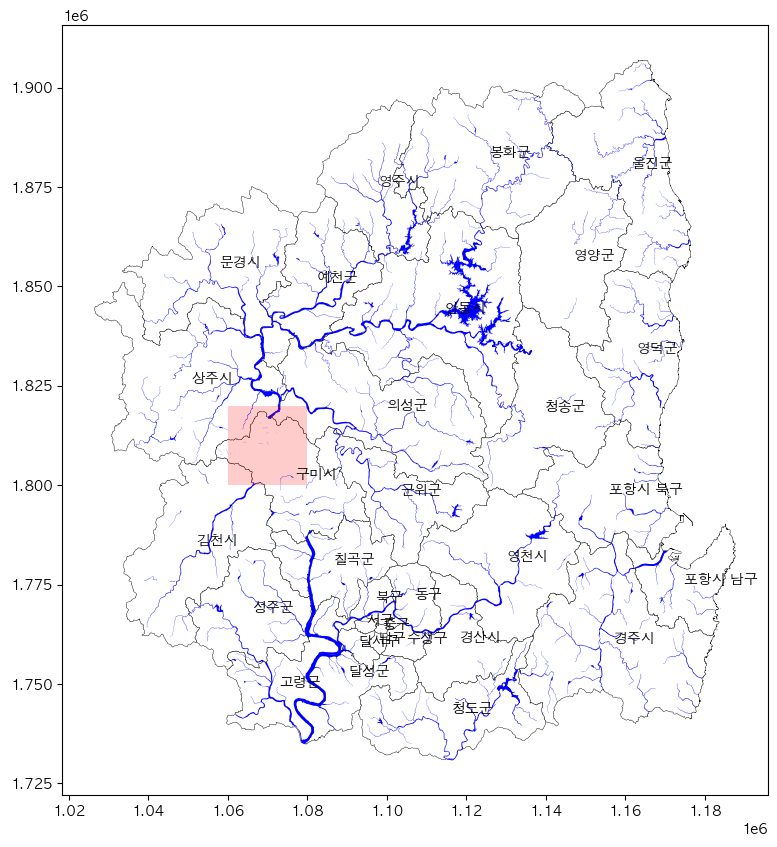

In [25]:
fig, ax=plt.subplots(1,1,figsize=(10,10)) 

dgb_sig_shp.plot(ax=ax,color='white',edgecolor='black',linewidth=0.3)
river_shp.buffer(10).plot(ax=ax,color='blue')
miss_gdf.plot(ax=ax,color='red',alpha=0.2)


for x,y,nm in zip(spot_x,spot_y,dgb_sig_shp.sig_kor_nm):
	plt.text(
		x,
		y,
		nm
	)
	
plt.show()

---
#### 2-3) 누락 하천구역 추가하기 
* QGIS 를 이용하여 직접 폴리곤 추가

In [26]:
gumi_river_shp = gpd.read_file(
	filename='./data/nakdong_river_modify/added_river.shp',
	encoding='EUC-KR'
)

gumi_river_shp['river_nm'] = '구미천'
gumi_river_shp['sig_cd'] = 47190

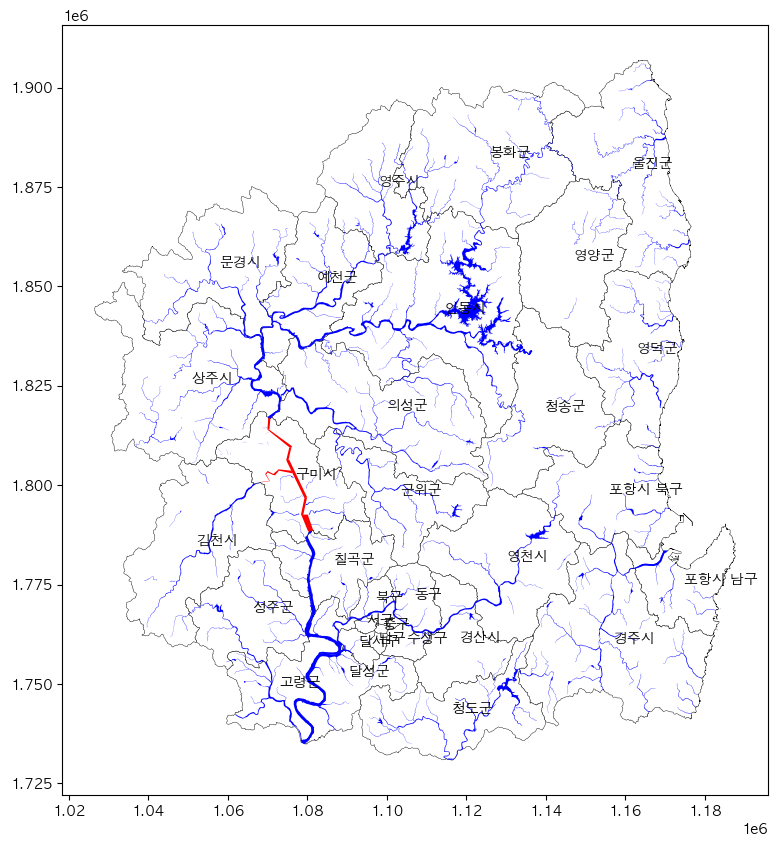

In [27]:
fig, ax=plt.subplots(1,1,figsize=(10,10)) 

dgb_sig_shp.plot(ax=ax,color='white',edgecolor='black',linewidth=0.3)
river_shp.buffer(10).plot(ax=ax,color='blue')
gumi_river_shp.plot(ax=ax,color='red')

for x,y,nm in zip(spot_x,spot_y,dgb_sig_shp.sig_kor_nm):
	plt.text(
		x,
		y,
		nm
	)
	
plt.show()

In [28]:
# 두 파일 결합 및 FID drop 

nakdong_river_shp = pd.concat(
	[
		river_shp,
		gumi_river_shp
	],
	ignore_index=True
)

nakdong_river_shp.drop(
	columns=[
		'FID'
	],
	inplace=True
)

In [29]:
# 크롤링 해야 하나 


In [199]:
water_spot = pd.read_csv(
	'./data/water_quality_measure_spot.csv',
	encoding='euc-kr'
)


water_spot = water_spot[
	[
		'구분',
		'지점코드',
		'지점명',
		'주소',
		'대권역',
		'중권역'
	]
]

---
#### 2-4) 구글맵 API 를 통한 위경도 받아오기

In [52]:
googlemaps_key = "" # 보안을 위해 일단 삭제 (본인 키를 입력하시면 됩니다.)
gmaps = googlemaps.Client(key=googlemaps_key)

* 주소 핸들링 및 위경도 추출하기

In [ ]:
lat = []
lng = []

for addr in water_spot['주소']:

	start_pattern = re.search('[\(]',addr)
	end_pattern = re.search('[\)]',addr)

	if start_pattern: 
		st_idx = start_pattern.start()
		end_idx = end_pattern.end()

		micro_addr = addr[0:st_idx]+addr[st_idx+1:end_idx-1]
		macro_addr = addr[0:st_idx]

	else:
		pass 
	
	try: 
		geo_location = gmaps.geocode(micro_addr)[0].get('geometry')

		lat.append(geo_location['location']['lat'])
		lng.append(geo_location['location']['lng'])

	except IndexError as e: 
		geo_location = gmaps.geocode(macro_addr)[0].get('geometry')

		lat.append(geo_location['location']['lat'])
		lng.append(geo_location['location']['lng'])
		

water_spot['lat'] = lat 
water_spot['lng'] = lng 

* geopandas 형태로 핸들링 및 좌표계 변환

In [218]:
water_spot['geometry'] = water_spot.apply(
	lambda dt: Point([dt['lng'],dt['lat']]),
	axis=1
)

water_spot_gdf = gpd.GeoDataFrame(water_spot)

# 좌표계 변경 

water_spot_gdf.crs = "epsg:4326"


water_spot_gdf.to_crs(
	{
		'init': 'epsg:5179'
	},
	inplace=True
)

water_spot_gdf

,구분,지점코드,지점명,주소,대권역,중권역,lat,lng,geometry
0,하천수,2001A10,황지1,강원도 태백시 동점동 (구문소교),낙동강,안동댐,37.094210,129.050950,POINT (1137831.665 1900633.778)
1,하천수,2001A20,철암천,강원도 태백시 동점동 (루사교),낙동강,안동댐,37.094210,129.050950,POINT (1137831.665 1900633.778)
2,하천수,2001A30,황지2,강원도 태백시 동점동 (동점역앞),낙동강,안동댐,37.084550,129.046403,POINT (1137444.998 1899555.471)
3,하천수,2001A36,석포3,경상북도 봉화군 석포면 승부리(결둔교),낙동강,안동댐,37.012725,129.067860,POINT (1139483.629 1891618.029)
4,하천수,2001A37,석포4,경상북도 봉화군 석포면 승부리(승부역),낙동강,안동댐,36.993671,129.083791,POINT (1140936.172 1889527.532)
...,...,...,...,...,...,...,...,...,...
190,하천수,2503A30,구천천,경상남도 거제시 상문동 산116-2,낙동강,거제도,34.903468,128.645856,POINT (1104686.315 1657122.147)
191,하천수,2504A10,창원천,경상남도 창원시 의창구 사화동(창원천교),낙동강,낙동강남해,35.251937,128.626128,POINT (1102447.266 1695748.657)
192,하천수,2504A20,내동천,경상남도 창원시 의창구 차용동(차룡8교),낙동강,낙동강남해,35.237651,128.632765,POINT (1103069.169 1694171.008)
193,하천수,2504A27,산호천,"경상남도 창원시 마산회원구 양덕동(메트로시티아파트 121동 인근, 양덕무지개 다리)",낙동강,낙동강남해,35.227309,128.582392,POINT (1098498.155 1692972.978)


In [239]:
dgb_water_spot_gdf = water_spot_gdf[
	water_spot_gdf['주소'].str.contains("경상북|대구")
]

* 수질 측정소 확인 

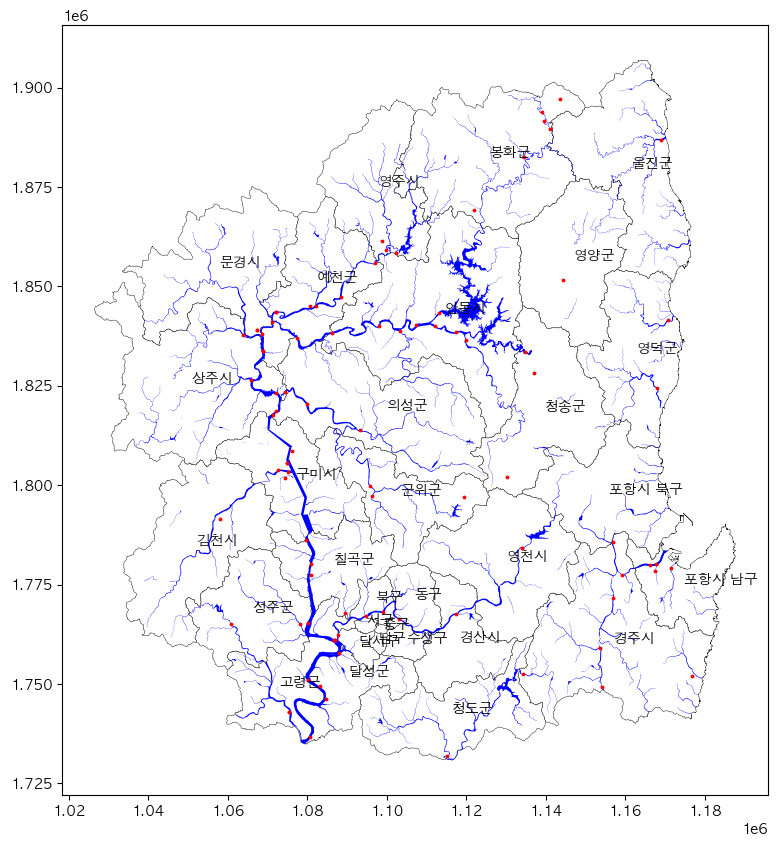

In [241]:
fig, ax=plt.subplots(1,1,figsize=(10,10)) 

dgb_sig_shp.plot(ax=ax,color='white',edgecolor='black',linewidth=0.3)
nakdong_river_shp.buffer(10).plot(ax=ax,color='blue')
dgb_water_spot_gdf.plot(ax=ax,color='red',markersize=3)

for x,y,nm in zip(spot_x,spot_y,dgb_sig_shp.sig_kor_nm):
	plt.text(
		x,
		y,
		nm
	)
	

---
#### 2-5) 공간결합 (시도,시군구,행정동 )

* 시도, 시군구 결합

In [286]:
dgb_shp = gpd.sjoin(
	dgb_sig_shp,
	dgb_sido_shp,
	how='left',
	predicate='within'
)


* 결합 후 누락 지역 확인 (버퍼 작업)

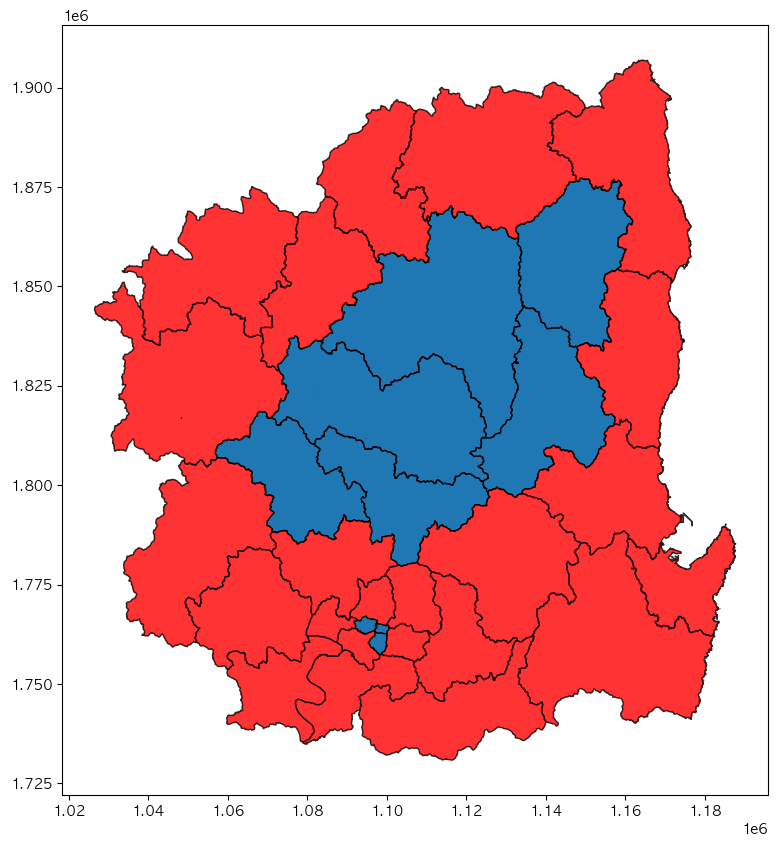

In [287]:
fig, ax=plt.subplots(1,1,figsize=(10,10)) 

dgb_shp[dgb_shp.index_right.notnull()].plot(ax=ax,edgecolor='black') # null이 아닌 지역 
dgb_shp[dgb_shp.index_right.isna()].plot(ax=ax,color='red',alpha=0.8,edgecolor='black') # null 인 지역

plt.show()

* 공간 결합을 위한 버퍼

In [398]:
buff_dgb_sido_shp = dgb_sido_shp.copy()
buff_dgb_sig_shp = dgb_sig_shp.copy()

buff_dgb_sido_shp['geometry'] = dgb_sido_shp.buffer(2)
buff_dgb_sig_shp['geometry'] = dgb_sig_shp.buffer(1)


join_dgb_sig_shp = gpd.sjoin(
	buff_dgb_sig_shp,
	buff_dgb_sido_shp,
	how='left',
	predicate='within'
)


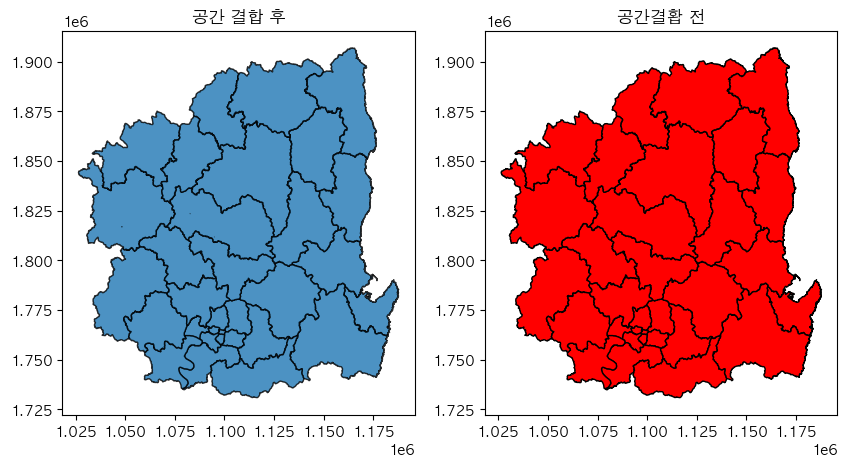

In [400]:
fig, ax=plt.subplots(1,2,figsize=(10,10)) 


# 시군구 shp
dgb_sig_shp.plot(ax=ax[0],alpha=0.8,edgecolor='black') # 원본 
ax[1].set_title('공간결홥 전')


# 결합 결과 중 not null인 케이스
join_dgb_sig_shp[join_dgb_sig_shp.index_right.notnull()].plot(ax=ax[1],color='red',edgecolor='black')
ax[0].set_title('공간 결합 후')

plt.show()

In [401]:
# 컬럼 정리
join_dgb_sig_shp.drop(
	columns=[
		'sido_eng_nm',
		'sig_eng_nm',
		'index_right'
	],
	inplace=True
)

* 행정동 공간결합

In [404]:
buff_dgb_sig_shp = dgb_sig_shp.copy()
buff_dgb_adm_shp = dgb_adm_shp.copy()


buff_dgb_sig_shp['geometry'] = dgb_sig_shp.buffer(2)
buff_dgb_adm_shp['geometry'] = dgb_adm_shp.buffer(1)


join_dgb_adm_shp = gpd.sjoin(
	buff_dgb_adm_shp,
	buff_dgb_sig_shp,
	how='left',
	predicate='within'
)


In [403]:
print('결측지역:' , sum(dgb_shp.index_right.isna()))


결측지역: 4


In [413]:
# 갔다와선 버퍼 준걸로 작업 하기 

buff_dgb_sig_shp = join_dgb_sig_shp.copy()
buff_dgb_adm_shp = dgb_adm_shp.copy()

buff_dgb_sig_shp['geometry'] = buff_dgb_sig_shp.buffer(3)
buff_dgb_adm_shp['geometry'] = dgb_adm_shp.buffer(1)


join_dgb_adm_shp = gpd.sjoin(
	buff_dgb_adm_shp,
	buff_dgb_sig_shp,
	how='left',
	predicate='within'
)

print(sum(join_dgb_adm_shp.index_right.isna()))

2


In [416]:
join_dgb_adm_shp[join_dgb_adm_shp.index_right.isna()]

,adm_cd,adm_eng_nm,adm_kor_nm,geometry,index_right,sig_cd,sig_kor_nm,sido_cd,sido_kor_nm
801,27230129,Geumho-dong,금호동,"POLYGON ((1091953.612 1767310.984, 1091951.868...",NaN,NaN,NaN,NaN,NaN
4163,47210390,Buseok-myeon,부석면,"POLYGON ((1101151.951 1895278.527, 1101154.150...",NaN,NaN,NaN,NaN,NaN


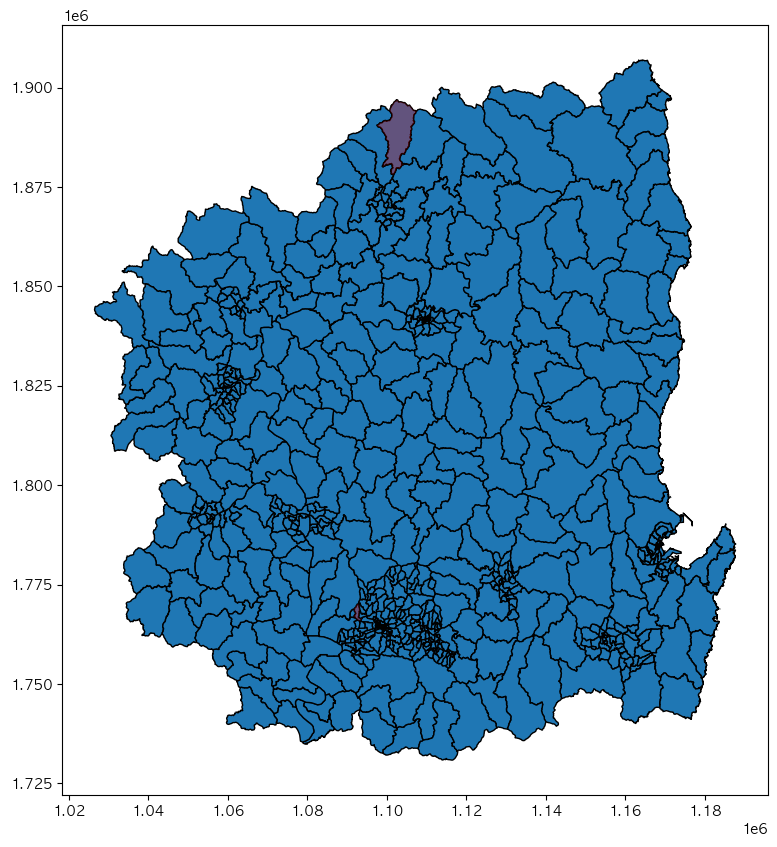

In [420]:
fig, ax=plt.subplots(1,1,figsize=(10,10)) 

join_dgb_adm_shp.plot(ax=ax,edgecolor='black') # 결합된 시군구 파일
join_dgb_adm_shp[join_dgb_adm_shp.index_right.isna()].plot(ax=ax,color='red',alpha=0.3,edgecolor='black') # 금호동/ 부석면 확인 


plt.show()

In [396]:
sum(join_dgb_adm_shp.index_right.isna())

2

---
* Ref) 

[하천용도 구역 shp 파일 다운로드](http://data.nsdi.go.kr/dataset/12843)